In [1]:
from util import *

Using device: cuda


In [2]:
genres = set()
for game in game_map:
    genres.add(game_map[game])
genres = list(genres)
indices = {}
for i, genre in enumerate(genres):
    indices[genre] = i
print(genres, indices)

['strategy', 'rpg', 'racing', 'puzzle', 'shooter'] {'strategy': 0, 'rpg': 1, 'racing': 2, 'puzzle': 3, 'shooter': 4}


In [3]:
upper_limit = {'train': 200, 'test': 20} # Evenly split the games among the limit

In [4]:
test_data = []
test_labels = []
train_data = []
train_labels = []

In [5]:
train_images = ('train', np.array(os.listdir(os.path.join('input_images', 'train'))))
test_images = ('test', np.array(os.listdir(os.path.join('input_images', 'test'))))

In [6]:
nt = transforms.Compose([ # Only tensor + normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
def get_genre(filename):
    genre = game_map[get_title(filename)]
    return genre

In [8]:
def get_title(filename):
    game_name = filename.split(';;')[0]
    return game_name

In [9]:
def n_games(genre, images): # n games in set
    distinct = set()
    for image in images[1]:
        if get_genre(image) == genre:
            distinct.add(get_title(image))
    return len(distinct)

In [10]:
def generate_inputs_split(images):
    genre_limits = {}
    for genre in genres:
        genre_limits[genre] = upper_limit[images[0]] // n_games(genre)
    game_count = {}
    data = []
    labels = []
    for image in images[1]:
        genre = get_genre(image)
        name = get_title(image)
        if name not in game_count:
            game_count[name] = 1
        elif game_count[name] < genre_limits[genre]:
            game_count[name] += 1
        else:
            continue
        classification = indices[genre]
        data.append(nt(Image.open(os.path.join('input_images', images[0], image)).convert('RGB')).numpy())
        labels.append(classification)
    return data, labels

In [11]:
def generate_inputs_all(images):
    data = []
    labels = []
    for image in images[1]:
        game_name = image.split(';;')[0]
        genre = game_map[game_name]
        classification = indices[genre]
        # video_number = int(image.split(';;')[1].split('_')[0])
        # sequence_number = int(image.split(';;')[1].split('_')[1].split('.')[0])
        data.append(nt(Image.open(os.path.join('input_images', images[0], image)).convert('RGB')).numpy())
        labels.append(classification)
    return (data, labels)

In [12]:
train_data, train_labels = generate_inputs_all(train_images)
test_data, test_labels = generate_inputs_all(test_images)

In [13]:
n_train = len(train_data)
n_test = len(test_data)
n_classes = len(genres)

print(f'Train size: {n_train}, Test Size: {n_test}, with {n_classes} classes')

Train size: 2575, Test Size: 359, with 5 classes


In [14]:
X_train_tensor = torch.tensor(np.array(train_data), device = device).float()
X_test_tensor = torch.tensor(np.array(test_data), device = device).float()
y_train_tensor = torch.tensor(train_labels, device = device)
y_test_tensor = torch.tensor(test_labels, device = device)

y_train_onehot = F.one_hot(y_train_tensor.to(torch.int64), num_classes=n_classes).float()
y_test_onehot = F.one_hot(y_test_tensor.to(torch.int64), num_classes=n_classes).float()

In [15]:
# define the training and testing mechanisms to load in images as datasets
BATCH_SIZE = 32

# first contruct the training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

# then the testing set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle = False)

In [16]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        # construct the convolutional layers
        # Output sizes are hyperparameters
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(24, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        conv_output_size = 28800
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Dropout(p=0.8),
            nn.Linear(conv_output_size, 625), 
            nn.ReLU(),
            # nn.Dropout(p=0.8),
            # nn.Linear(2500, 1250),
            # nn.ReLU(),

            # nn.Dropout(p=0.8),
            # nn.Linear(1250, 625),
            # nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(625, 5)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [17]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    correct_class = {}
    total_class = {}
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        label = int(labels[i])
        if differences[i]==0:
            correct +=1
        else:
            correct_class[label] = (0 if label not in correct_class else correct_class[label]) + 1
        total_class[label] = (0 if label not in total_class else total_class[label]) + 1
        total += 1
    return(correct, total, correct_class, total_class)

In [18]:
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
# note that this uses the given model object's parameters
# and therefore must be defined after the model is defined 
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# define the number of epochs
NUM_EPOCHS = 10

# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

# make empty lists to keep track of the training and testing losses
train_losses = []
test_losses = []
stats = {}

# loop through each epoch to run the training loop
# and check the model with the training data
# keep track of both sets of losses as you go
for epoch in range(NUM_EPOCHS):
    
    # Run the training loop (put model in training mode)
    model.train()

    total_train_loss = 0.0
    total_train_correct = 0
    total_train_images = 0
    
    for train_inputs, train_labels in train_loader:
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        # implement the forward method
        optimizer.zero_grad()
        outputs = model(train_inputs)

        # compute stats
        train_correct, train_total, _, _ = compute_correct_labels(outputs, train_labels)
        total_train_correct += train_correct
        total_train_images += train_total

        # implement the loss and the backward method
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # compute stats
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Run the testing loop (put model in eval mode)
    model.eval()
    
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_images = 0
    
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # implement the forward method
            outputs = model(test_inputs)

            # compute stats
            test_correct, test_total, correct_class, total_class = compute_correct_labels(outputs, test_labels)
            total_test_correct += test_correct
            total_test_images += test_total
            loss = criterion(outputs, test_labels)
            total_test_loss += loss.item()
            for genre in total_class:
                i = int(genre)
                stats[i] = (correct_class[genre] if genre in correct_class else 0) / total_class[genre]
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
          f" - TR Loss: {avg_train_loss:.4f}, "+\
          f"TR # Correct: {total_train_correct}/{total_train_images}, "+\
          f" TR % Correct: {(total_train_correct * 100) / total_train_images:.2f}%, " +\
          f"| TS Loss: {avg_test_loss:.4f}, "+\
          f"TS # Correct: {total_test_correct}/{total_test_images}, "+\
          f"TS % Correct: {(total_test_correct * 100) / total_test_images:.2f}%")

Epoch 1/10 - TR Loss: 1.3420, TR # Correct: 1127/2575,  TR % Correct: 43.77%, | TS Loss: 1.4661, TS # Correct: 166/359, TS % Correct: 46.24%
Epoch 2/10 - TR Loss: 0.8495, TR # Correct: 1757/2575,  TR % Correct: 68.23%, | TS Loss: 1.4129, TS # Correct: 182/359, TS % Correct: 50.70%
Epoch 3/10 - TR Loss: 0.6184, TR # Correct: 2019/2575,  TR % Correct: 78.41%, | TS Loss: 1.6488, TS # Correct: 178/359, TS % Correct: 49.58%
Epoch 4/10 - TR Loss: 0.4905, TR # Correct: 2171/2575,  TR % Correct: 84.31%, | TS Loss: 1.5435, TS # Correct: 181/359, TS % Correct: 50.42%
Epoch 5/10 - TR Loss: 0.3813, TR # Correct: 2256/2575,  TR % Correct: 87.61%, | TS Loss: 1.2548, TS # Correct: 186/359, TS % Correct: 51.81%


KeyboardInterrupt: 

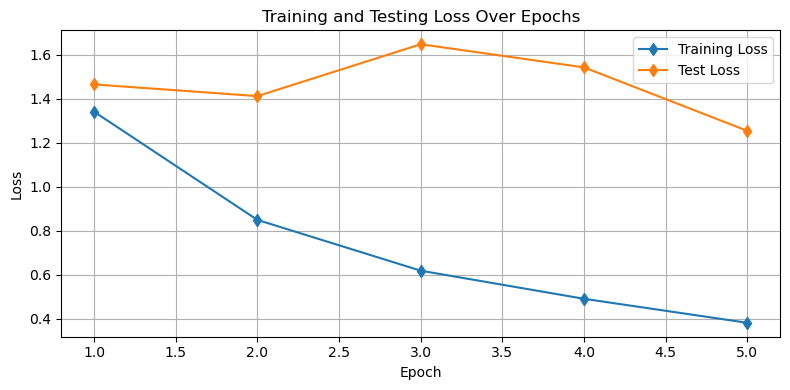

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

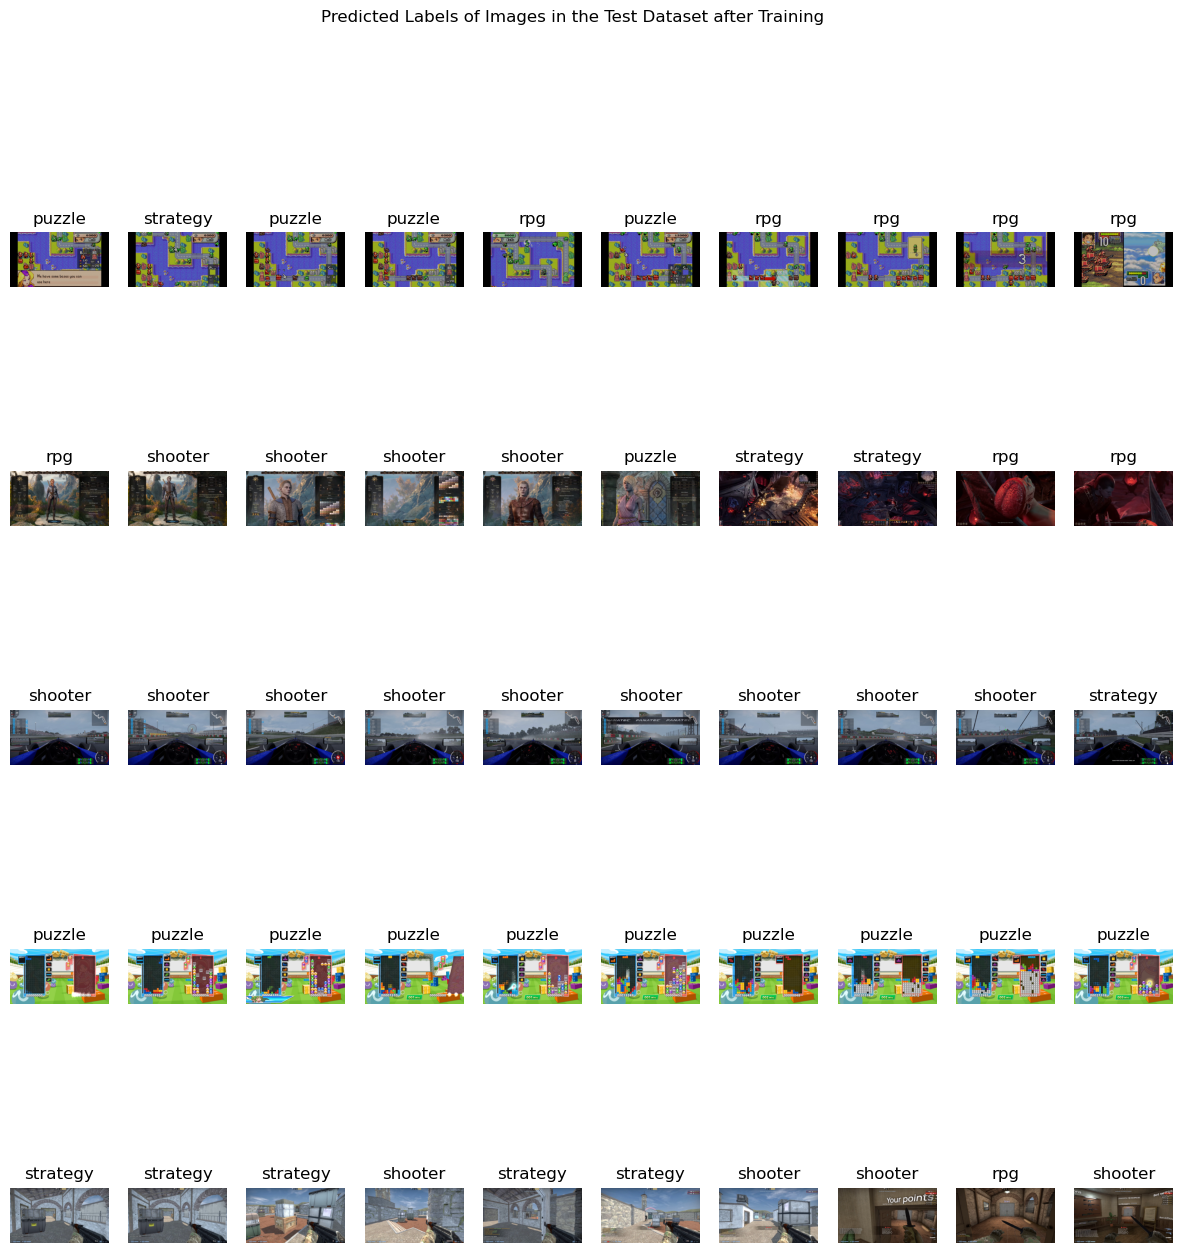

In [20]:
# Set model to evaluation mode
model.eval()

# make a figure object
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(5, 10)

counts = {} # test_data, test_labels
file_count = 0
validation_data, validation_labels = generate_inputs_all(test_images)

for i in range(len(validation_data)):
    if validation_labels[i] in counts:
        if counts[validation_labels[i]] >= 10:
            continue
        counts[validation_labels[i]] += 1
    else:
        file_count = 0
        counts[validation_labels[i]] = 1
    input_tensor = torch.from_numpy(validation_data[i]).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    predicted_class = genres[predicted.item()]
    # add the image to the plot with the prediction
    ax = fig.add_subplot(gs[validation_labels[i], file_count])
    ax.imshow(Image.open(os.path.join('input_images', 'test', test_images[1][i])))
    ax.axis('off')
    ax.set_title(predicted_class)
    file_count += 1

plt.suptitle('Predicted Labels of Images in the Test Dataset after Training')
plt.show()